<a href="https://colab.research.google.com/github/erendagasan/Eren-Dagasan-Personal/blob/main/ARIMA-14.09.2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

In [43]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import yfinance as yf

stock = "NFLX"

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = yf.download(stock, start="2006-01-01", end="2023-09-14")

df_close = stock_data['Close']
df_log = np.log(df_close)
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

best_order = model_autoARIMA.order
print("Best ARIMA Order:", best_order)

[*********************100%%**********************]  1 of 1 completed
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16210.980, Time=1.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16210.848, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16210.885, Time=1.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16206.494, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16209.035, Time=0.88 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 4.303 seconds
Best ARIMA Order: (0, 1, 0)


In [44]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta

start="2023-07-03"
end="2023-09-11"

stock_data = yf.download(stock, start=start, end=end, progress=False)
new_date_index = stock_data.index + pd.Timedelta(days=(pd.Timestamp(end)-pd.Timestamp(start)+pd.Timedelta(1)).days)
model = ARIMA(np.log(stock_data["Close"]), order=best_order)
fitted = model.fit()

print(len(stock_data))

48


FİYAT:  412.24 TL

ÜST PROJEKSİYON:  603.28 TL
ALT PROJEKSİYON:  325.01 TL

Günlük AL noktası:  409.85 TL


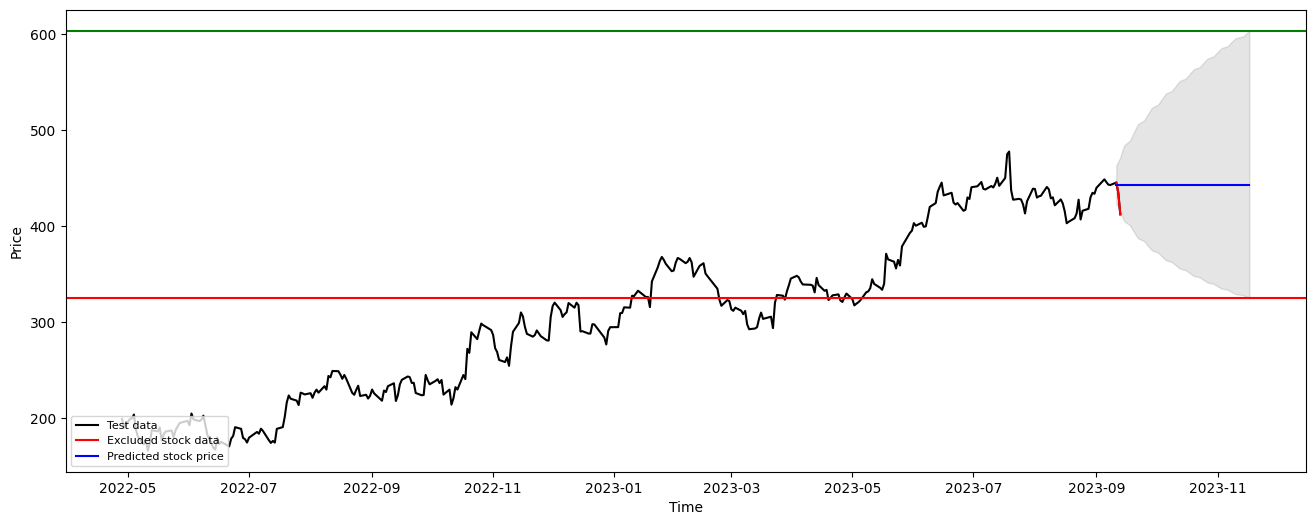

In [45]:
forecast_results = fitted.get_forecast(steps=len(stock_data), alpha=0.05)

fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=stock_data.index)
lower_series = pd.DataFrame([new_date_index,conf.iloc[:, 0]]).T
# upper_series = pd.Series(stock_data.index, conf.iloc[:, 1])

plt.figure(figsize=(16,6), dpi=100)
# plt.plot(np.exp(train_data[3500:]), label='Training data', color="black")
plt.plot(np.exp(test_data[100:]), color='black', label='Test data')

# plt.plot(test_data.index, np.exp(fc), color='orange', label='Predicted Stock Price')  # Convert back to original scale
# plt.fill_between(test_data.index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]),
#                  color='k', alpha=.10)


from datetime import datetime, timedelta
today = datetime.now()
tomorrow = today + timedelta(days=1)
formatted_date = tomorrow.strftime("%Y-%m-%d")
today = today.strftime("%Y-%m-%d")

stock_data = yf.download(stock, start=end, end=formatted_date, progress=False)
plt.plot(stock_data.index, stock_data["Close"], color='red', label='Excluded stock data')

plt.plot(new_date_index, np.exp(fc), color='blue', label='Predicted stock price')  # Convert back to original scale
plt.fill_between(new_date_index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]),
                 color='k', alpha=.10)

plt.axhline(np.exp(conf.iloc[:, 1].max()), color="green")
plt.axhline(np.exp(conf.iloc[:, 0].min()), color="red")

print("FİYAT: ", round(stock_data["Close"].iloc[-1], 2), "TL\n")

print("ÜST PROJEKSİYON: ", round(np.exp(conf.iloc[:, 1].max()), 2), "TL")
print("ALT PROJEKSİYON: ", round(np.exp(conf.iloc[:, 0].min()), 2), "TL\n")

print("Günlük AL noktası: ", round(np.exp(float(lower_series[1][lower_series[0] == pd.Timestamp(today)])), 2), "TL")

plt.xlabel('Time')
plt.ylabel('Price')

plt.legend(loc='lower left', fontsize=8)
plt.show()

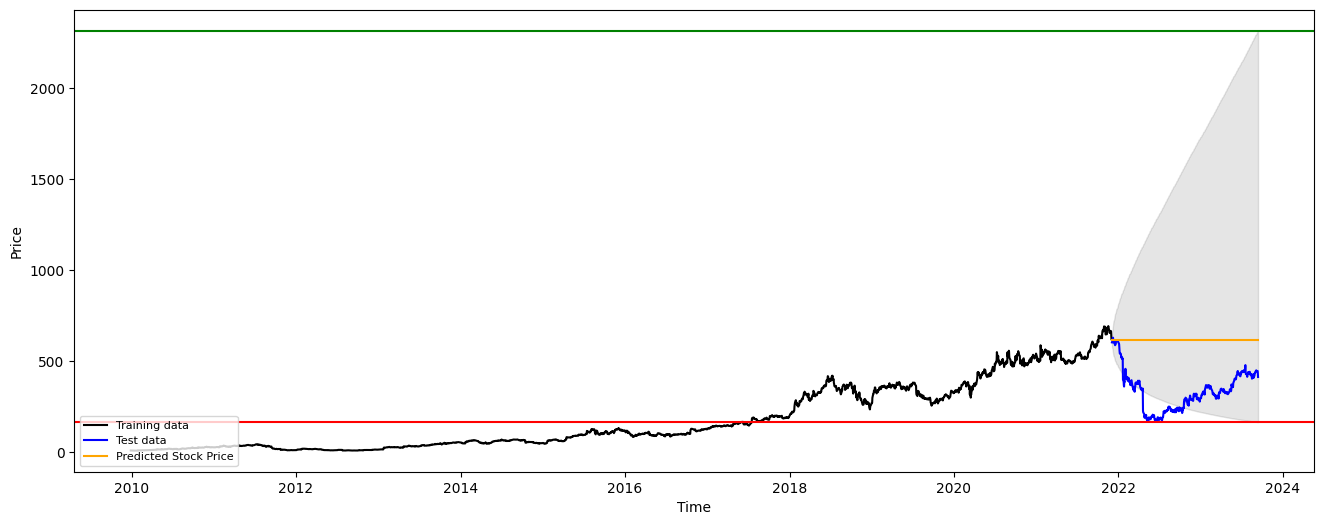

In [46]:
model = ARIMA(train_data, order=best_order)
fitted = model.fit()

forecast_results = fitted.get_forecast(steps=len(test_data), alpha=0.05)

fc = forecast_results.predicted_mean
conf = forecast_results.conf_int()

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

plt.figure(figsize=(16,6), dpi=100)
plt.plot(np.exp(train_data[1000:]), label='Training data', color="black")
plt.plot(np.exp(test_data), color='blue', label='Test data')

plt.plot(test_data.index, np.exp(fc), color='orange', label='Predicted Stock Price')  # Convert back to original scale
plt.fill_between(test_data.index, np.exp(conf.iloc[:, 0]), np.exp(conf.iloc[:, 1]),
                 color='k', alpha=.10)


plt.axhline(np.exp(conf.iloc[:, 1].max()), color="green")
plt.axhline(np.exp(conf.iloc[:, 0].min()), color="red")

plt.xlabel('Time')
plt.ylabel('Price')

plt.legend(loc='lower left', fontsize=8)
plt.show()

In [27]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc.to_numpy() - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.2674679937215887
MAE: 0.4483644851402625
RMSE: 0.5171730790766169
MAPE: 0.08581938413187133


In [ ]:
import requests
from bs4 import BeautifulSoup

market = []

url = f"https://tr.tradingview.com/symbols/BIST-XU100/components/"
response = requests.get(url)

if response.status_code == 200:
  soup = BeautifulSoup(response.text, 'html.parser')
  elements = soup.find_all(class_="apply-common-tooltip tickerNameBox-GrtoTeat tickerName-GrtoTeat")

  for element in elements:
    text = element.get_text()
    market.append(text)

for stock in market:
  try:
    print(stock)
    stock = stock+".IS"
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
    stock_data = yf.download(stock, start="2006-01-01", end="2023-09-14", progress=False)

    df_close = stock_data['Close']
    df_log = np.log(df_close)
    train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

    model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                          test='adf',
                          max_p=3, max_q=3,
                          m=1,
                          d=None,
                          seasonal=False,
                          start_P=0,
                          D=0,
                          trace=False,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

    best_order = model_autoARIMA.order

    print("Best param search is done. \n")
    # print("Best ARIMA Order:", best_order)

    start="2023-08-28"
    end="2023-09-11"

    stock_data = yf.download(stock, start=start, end=end, progress=False)
    new_date_index = stock_data.index + pd.Timedelta(days=(pd.Timestamp(end)-pd.Timestamp(start)+pd.Timedelta(1)).days)
    model = ARIMA(np.log(stock_data["Close"]), order=best_order)
    fitted = model.fit()

    # print(len(stock_data))

    forecast_results = fitted.get_forecast(steps=len(stock_data), alpha=0.05)

    fc = forecast_results.predicted_mean
    conf = forecast_results.conf_int()

    fc_series = pd.Series(fc, index=stock_data.index)
    lower_series = pd.DataFrame([new_date_index,conf.iloc[:, 0]]).T

    from datetime import datetime, timedelta
    today = datetime.now()
    tomorrow = today + timedelta(days=1)
    formatted_date = tomorrow.strftime("%Y-%m-%d")
    today = today.strftime("%Y-%m-%d")

    stock_data = yf.download(stock, start=end, end=formatted_date, progress=False)

    if round(stock_data["Close"].iloc[-1], 2) < round(np.exp(float(lower_series[1][lower_series[0] == pd.Timestamp(today)])), 2):
      print("****************",stock,"****************", "\n")
  except:
    print("Error with this stock.\n")

AEFES
Best param search is done. 

AGHOL
Best param search is done. 

AHGAZ
Best param search is done. 

AKBNK
Best param search is done. 

**************** AKBNK.IS **************** 

AKCNS
Best param search is done. 

AKFGY
Best param search is done. 

AKSA
Best param search is done. 

AKSEN
Best param search is done. 

ALARK
Best param search is done. 

ALBRK
Best param search is done. 



ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ALFAS.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


**************** ALBRK.IS **************** 

ALFAS
Error with this stock.

ARCLK
Best param search is done. 

ASELS
Best param search is done. 

ASTOR


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ASTOR.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


Error with this stock.

ASUZU
Best param search is done. 

AYDEM
Best param search is done. 

BAGFS
Best param search is done. 

BERA
Best param search is done. 

BIMAS
Best param search is done. 

BIOEN


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BIOEN.IS']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")


Error with this stock.

BRSAN
Best param search is done. 

BRYAT
Best param search is done. 

BUCIM
Best param search is done. 

CANTE
Best param search is done. 

CCOLA
Best param search is done. 

CEMTS
Best param search is done. 

CIMSA
Best param search is done. 

DOAS
Best param search is done. 

DOHOL
Best param search is done. 

**************** DOHOL.IS **************** 

ECILC
Best param search is done. 

ECZYT
